Select a currency pair from the following:
1. USD/INR
2. EUR/INR
3. JPY/INR
4. GBP/INR
Index(['Open_price', 'Day_high', 'Day_low', 'Closing_price', 'Currency Pair'], dtype='object')
Missing values before scaling:
Open_price                   0
Day_high                     0
Day_low                      0
Deseasonalized_Day_high      0
Deseasonalized_Day_low       0
Deseasonalized_Open_price    0
EMA_100                      0
EMA_200                      0
EMA_50                       0
MACD                         0
Signal_Line                  0
MACD_Histogram               0
SMA                          0
Upper Band                   0
Lower Band                   0
dtype: int64
Any NaN in df_scaled? 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Predicted Closing Prices for Next 7 Days:
Day 1: 90.4634
Day 2: 90.1955
Day 3: 90.3833
Day 4: 90.1138
Day 5: 90.1589
Day 6: 90.1929
Day 7: 90.4335


c:\Users\Sejal Hanmante\OneDrive\Documents\GitHub\ForEx\pipelines\swing_technical_indicators\indicators.py:202: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bands.fillna(method='ffill', inplace=True)  # Forward-fill
c:\Users\Sejal Hanmante\OneDrive\Documents\GitHub\ForEx\pipelines\swing_technical_indicators\indicators.py:203: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bands.fillna(method='bfill', inplace=True)  # Backward-fill
d:\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
d:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as th

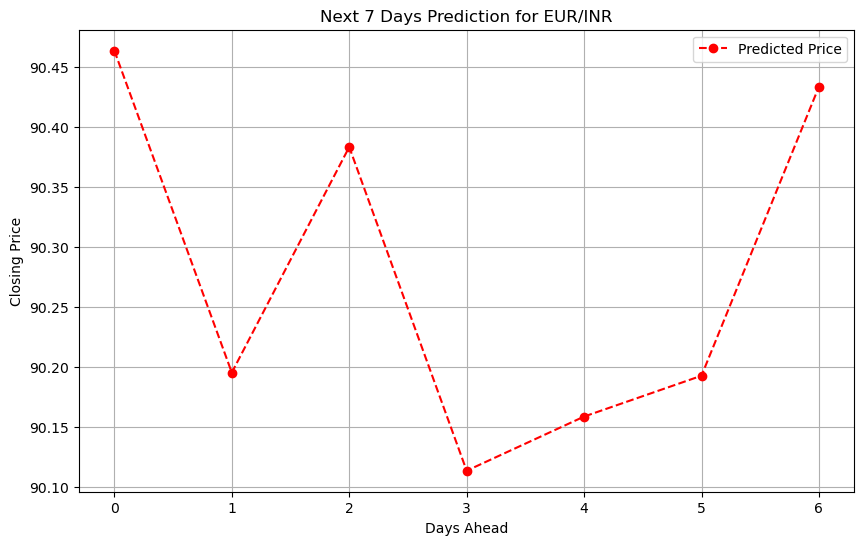

Index(['Open_price', 'Day_high', 'Day_low', 'Deseasonalized_Day_high',
       'Deseasonalized_Day_low', 'Deseasonalized_Open_price', 'EMA_100',
       'EMA_200', 'EMA_50', 'MACD', 'Signal_Line', 'MACD_Histogram', 'SMA',
       'Upper Band', 'Lower Band'],
      dtype='object')

In [12]:
# User selects a currency pair
import joblib
import os
import numpy as np
import pandas as pd
import requests
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import swing_technical_indicators 

# Set API Key for Alpha Vantage
#api_key = '89PMD611NPUTS89W'
api_key = 'EWTP9LXAZRDLRHB8'

# Function to fetch Forex data
def fetch_forex_data(from_currency, to_currency):
    url = f'https://www.alphavantage.co/query'
    params = {
        'function': 'FX_DAILY',
        'from_symbol': from_currency,
        'to_symbol': to_currency,
        'apikey': api_key,
        'outputsize': 'compact'
    }
    response = requests.get(url, params=params)
    data = response.json()

    time_series = data.get('Time Series FX (Daily)', {})
    df = pd.DataFrame.from_dict(time_series, orient='index')
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    df.rename(columns={
        "1. open": "Open_price",
        "2. high": "Day_high",
        "3. low": "Day_low",
        "4. close": "Closing_price"
    }, inplace=True)

    df['Currency Pair'] = f'{from_currency}/{to_currency}'

    # Filter past 60 days to ensure enough data for sequences
    last_100_days = datetime.now() - timedelta(days=100)
    df = df[df.index >= last_100_days]

    return df

# Available currency pairs
currency_pairs = ["USD/INR", "EUR/INR", "JPY/INR", "GBP/INR"]

print("Select a currency pair from the following:")
for i, pair in enumerate(currency_pairs, 1):
    print(f"{i}. {pair}")

choice = int(input("Enter the number corresponding to your choice: "))
selected_pair = currency_pairs[choice - 1]

from_currency, to_currency = selected_pair.split("/")

# Fetch data for selected currency pair
df = fetch_forex_data(from_currency, to_currency)
print(df.columns)
df["Open_price"] = pd.to_numeric(df["Open_price"], errors='coerce')
df["Day_high"] = pd.to_numeric(df["Day_high"], errors='coerce')
df["Day_low"] = pd.to_numeric(df["Day_low"], errors='coerce')
df["Closing_price"] = pd.to_numeric(df["Closing_price"], errors='coerce')

#print(df.dtypes)
from statsmodels.tsa.seasonal import seasonal_decompose

def deseasonalize_column(data, column, period=7):
    # Decompose the column
    decomposition = seasonal_decompose(data[column], model='additive', period=period, extrapolate_trend='freq')
    
    # Extract the residual component as deseasonalized data
    deseasonalized = data[column] - decomposition.seasonal
    
    return deseasonalized

# Identify non-stationary columns
non_stationary_columns = ['Day_high', 'Day_low', 'Open_price']

# Create deseasonalized columns
for col in non_stationary_columns:
    deseasonalized_col = deseasonalize_column(df, col, period=14)  # Adjust the period as needed
    df[f'Deseasonalized_{col}'] = deseasonalized_col

df['EMA_100'] = swing_technical_indicators.calculate_100ema(df, 'Closing_price', 100)
df['EMA_200'] = swing_technical_indicators.calculate_200ema(df, 'Closing_price', 200)
df['EMA_50'] = swing_technical_indicators.calculate_100ema(df, 'Closing_price', 50)
#df['RSI'] = swing_technical_indicators.calculate_rsi(df,'Closing_price',21)

data_macd = swing_technical_indicators.calculate_macd(df, column_name='Closing_price', short_period=12, long_period=26, signal_period=9)
#print(data_macd.columns)

for i in data_macd.columns:
    #print(i)
    df[f"{i}"] = data_macd[i]

bollinger_data = swing_technical_indicators.calculate_bollinger_bands(df['Closing_price'])
y = df["Closing_price"]
df = df.join(bollinger_data)
df.drop('Price',axis=1, inplace=True)
df.drop('Closing_price',axis=1, inplace=True)
df.drop('Currency Pair',axis=1, inplace=True)
print("Missing values before scaling:")
print(df.isna().sum())
# Load saved scalers

scaler_X = joblib.load(r'C:\Users\Sejal Hanmante\OneDrive\Documents\GitHub\ForEx\EURINR\eurinrscalerx')
scaler_y = joblib.load(r'C:\Users\Sejal Hanmante\OneDrive\Documents\GitHub\ForEx\EURINR\eurinrscalery')

# Normalize data
df_scaled = scaler_X.transform(df)
print("Any NaN in df_scaled?", np.isnan(df_scaled).sum())


#print(df_scaled)
# Function to create sequences for CNN
def create_sequences(X, y, sequence_length, forecast_horizon=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length - forecast_horizon + 1):  
        X_seq.append(X[i:i + sequence_length])  
        y_seq.append(y[i + sequence_length : i + sequence_length + forecast_horizon])  # Next 7 values
    return np.array(X_seq), np.array(y_seq)



# Create sequences
X_seq, y_seq = create_sequences(df_scaled,y,sequence_length = 30,forecast_horizon=7)
#print(X_seq)
# Ensure correct input shape
sequence_length = 30
feature_count = X_seq.shape[2]  # Number of features

# Define CNN Model
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(sequence_length, feature_count)),
    MaxPooling1D(2),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(7)  # Output layer for predicting next 7 days
])

# Load saved weights
cnn_model.load_weights(r"C:\Users\Sejal Hanmante\OneDrive\Documents\GitHub\ForEx\EURINR\eurinrmodel.h5")
#print(cnn_model.get_weights())
# Predict next 7 days
y_pred_scaled = cnn_model.predict(X_seq[-1].reshape(1, sequence_length, feature_count))

#print(y_pred_scaled)
# Convert predictions back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Print results
print("\nPredicted Closing Prices for Next 7 Days:")
for i, price in enumerate(y_pred.flatten(), 1):
    print(f"Day {i}: {price:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot( y_pred.flatten(), marker='o', linestyle="--", color="red", label="Predicted Price")
plt.xlabel("Days Ahead")
plt.ylabel("Closing Price")
plt.title(f"Next 7 Days Prediction for {selected_pair}")
plt.legend()
plt.grid()
plt.show()


df.columns
